In [142]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from finta import TA

from datetime import date
import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import datetime
import preprocessor as p

In [17]:
from tcn import compiled_tcn
from wordcloud import WordCloud


In [126]:
def getNextDay(y, m, d):
    gDate = datetime.datetime(y, m, d)
    nextday = gDate + datetime.timedelta(days=1)
    nDate = '{:%Y-%m-%d}'.format(nextday)
    return nDate

In [3]:
def updown(v):
    return 'Up' if v==1 else 'Down'

In [4]:

def process_date(date):
    datearr = date.split('-')

    newdate = datearr[0]

    newdate += '-'
    if len(datearr[1]) == 1:
        newdate += '0'
    newdate += datearr[1]

    newdate += '-'
    if len(datearr[2]) == 1:
        newdate += '0'
    newdate += datearr[2]

    return newdate


In [120]:
import snscrape.modules.twitter as sntwitter


In [132]:

def textclean(t):
    '''
    This function cleans the tweets.
    '''
    t = t.lower()  # convert to lowercase
    t = t.replace('\\', "+")
    t = re.sub('\\\\u[0-9A-Fa-f]{4}', '', t)  # remove NON- ASCII characters
    t = re.sub("[0-9]", "", t)  # remove numbers # re.sub("\d+", "", t)
    t = re.sub('[#!"$%&\'()*+,-./:@;<=>?[\\]^_`{|}~]', '', t)  # remove punctuations

    return t


In [138]:

def remove_emoji(text):
    p.set_options(p.OPT.URL, p.OPT.EMOJI)
    return p.clean(text)


In [143]:

def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)

    if sentiment_dict['compound'] >= 0.05:
        return 1

    elif sentiment_dict['compound'] <= - 0.05:
        return -1

    else:
        return 0


In [121]:
def date_prediction(company_name, year, month, day):
    start_date = "{}-{}-{}".format(year, str(month).zfill(2), str(day).zfill(2))
    end_date = getNextDay(year, month, day)

    search_content = "{} + since:{} until:{} -filter:links -filter:replies".format(company_name, start_date, end_date)

    texts_list = []
    sentence_list = []
    pos = 0
    neg = 0
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(search_content).get_items()):
        texts_list.append(tweet.content)
        if i == 59:
            break
    # print(len(texts_list))
    for j in range(0, min(60, len(texts_list)), 1):
        sentence = texts_list[j]
        if sentence:
            sentence = textclean(sentence)
            if sentence:
                sentence = remove_emoji(sentence)
                sentence = textclean(sentence)
                sentence_list.append(sentence)

                if sentiment_scores(sentence) == 1:
                    pos += 1
                elif sentiment_scores(sentence) == -1:
                    neg += 1

    if pos == 0 and neg == 0:
        pos_rate = 0
        neg_rate = 0
    else:
        pos_rate = pos / (pos + neg)
        neg_rate = neg / (pos + neg)

    s = ' '.join(sentence_list)
    return s, pos_rate, neg_rate

In [84]:
from sentimentanalysis import sentiment_analysis
def gather_data(company, start_time, end_time):

    # the time of tweets collected, change it when collecting more tweets to train the model
    start_time = "2018-01-01"
    end_time = "2022-05-07"

    sentiment = sentiment_analysis(company)
    
    
    stock = pd.read_csv("data/stock/{}.csv".format(company))
    
    
    
    data = sentiment.merge(stock, how='inner', left_on='date',right_on='Date')
    data.drop(data[(data.pos == 0) & (data.neg == 0)].index, inplace=True)
    data = data.reset_index(drop=True)
    

    # data = stock
    last_idx = data.shape[0] - 1

    hist_data = []
    for i in range(20, last_idx):
        hist_data.append([data['Open'][i], data['High'][i], data['Low'][i], data['Close'][i], data['Adj Close'][i],
                          data['Volume'][i]])

    # Technical Indicators
    stock = data
    ema = TA.EMA(stock, 50).round(decimals=8)
    adx = TA.ADX(stock).round(decimals=8)
    macd = TA.MACD(stock).round(decimals=8)
    rsi = TA.RSI(stock).round(decimals=8)
    sar = TA.SAR(stock).round(decimals=8)
    cci = TA.CCI(stock).round(decimals=8)
    stoch = TA.STOCH(stock).round(decimals=8)
    bop = TA.BOP(stock).round(decimals=8)
    do = TA.DO(stock).round(decimals=8)
    vwap = TA.VWAP(stock).round(decimals=8)

    indicators = []
    for i in range(20, last_idx):
        ind = [ema[i], adx[i], macd['MACD'][i], rsi[i], sar[i], cci[i], stoch[i], bop[i], do['MIDDLE'][i], vwap[i]]
        indicators.append(ind)

    # predicted needed data
    stock_data = np.concatenate((hist_data, indicators), 1)

    # add label
    label = []
    for i in range(20, last_idx):
        if data['Open'][i + 1] >= data['Open'][i]:
            label.append(1)
        else:
            label.append(0)
    label = np.array(label)

    print("Num of class=0: ", sum(i == 0 for i in label))
    print("Num of class=1: ", sum(i == 1 for i in label))

    # Min-Max normalization
    scaler = MinMaxScaler()
    scaler.fit(stock_data)

    stock_data = scaler.transform(stock_data)

    # add sentiment analysis
    pos = np.array(data[20:last_idx]['pos']).reshape((data[20:last_idx]['pos'].shape[0], 1))
    neg = np.array(data[20:last_idx]['neg']).reshape((data[20:last_idx]['neg'].shape[0], 1))
    stock_data = np.concatenate((stock_data, pos, neg), 1)

    print(stock_data)
    return stock_data, label    

gather_data("GOOG","2018-01-01","2022-05-07")  

Num of class=0:  496
Num of class=1:  577
[[0.09531495 0.08313142 0.09322168 ... 0.1084312  0.66666667 0.33333333]
 [0.09145719 0.08362197 0.09242763 ... 0.11354981 0.61290323 0.38709677]
 [0.07177577 0.05863742 0.06764907 ... 0.10785376 0.62068966 0.37931034]
 ...
 [0.63208736 0.6589533  0.6400939  ... 0.99748465 0.5        0.5       ]
 [0.65979444 0.67818843 0.67192895 ... 0.99842911 0.80952381 0.19047619]
 [0.6717991  0.71589331 0.6631651  ... 1.         0.64705882 0.35294118]]


(array([[0.09531495, 0.08313142, 0.09322168, ..., 0.1084312 , 0.66666667,
         0.33333333],
        [0.09145719, 0.08362197, 0.09242763, ..., 0.11354981, 0.61290323,
         0.38709677],
        [0.07177577, 0.05863742, 0.06764907, ..., 0.10785376, 0.62068966,
         0.37931034],
        ...,
        [0.63208736, 0.6589533 , 0.6400939 , ..., 0.99748465, 0.5       ,
         0.5       ],
        [0.65979444, 0.67818843, 0.67192895, ..., 0.99842911, 0.80952381,
         0.19047619],
        [0.6717991 , 0.71589331, 0.6631651 , ..., 1.        , 0.64705882,
         0.35294118]]),
 array([0, 0, 0, ..., 1, 1, 1]))

2.11.0


In [85]:

def knn_model(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc, knn


In [86]:

def logisticReg_model(X_train, X_test, y_train, y_test):
    lr = LogisticRegression(random_state = 0)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    return acc, lr


In [87]:
def decisionTree_model(X_train, X_test, y_train, y_test):
    dt_entropy = RandomForestClassifier(max_depth=3, random_state=0)
    dt_entropy.fit(X_train, y_train)
    y_pred = dt_entropy.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    return acc, dt_entropy

In [88]:

def svm_model(X_train, X_test, y_train, y_test):
    svm = sklearn.svm.SVC(kernel='rbf')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    return acc, svm

In [89]:

def naiveBayes_model(X_train, X_test, y_train, y_test):
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    return acc, gnb

In [90]:
def LSTM_model(X_train, X_test, y_train, y_test, epochs):
    model = Sequential()
    model.add(LSTM(50))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=0)

    y_pred_prob = model.predict(X_test)
    y_pred = []
    for prob in y_pred_prob:
        if prob < 0.5:
            y_pred.append(0)
        else:
            y_pred.append(1)

    acc = accuracy_score(y_test, y_pred)

    return acc, model



In [91]:


def tcn_model(X_train, X_test, y_train, y_test):
    tcn = compiled_tcn(
        return_sequences=False,
        num_feat=1,
        num_classes=2,
        nb_filters=30,
        kernel_size=2,
        dilations=[2 ** i for i in range(9)],
        nb_stacks=1,
        max_len=X_train.shape[1],
        use_skip_connections=True,
        use_weight_norm=True,
        dropout_rate=0.1)

    tcn.fit(X_train, y_train, epochs=30, verbose=0)

    y_pred_prob = tcn.predict(X_test)
    y_pred = []
    for prob in y_pred_prob:
        if prob[0] > prob[1]:
            y_pred.append(0)
        else:
            y_pred.append(1)
    acc = accuracy_score(y_test, y_pred)

    return acc, tcn


In [198]:



def risk_prediction_ml(X_train, X_test, y_train, y_test, today):
    acc_list = {}
    pred = {}
    acc_list['knn'], knn = knn_model(X_train, X_test, y_train, y_test)
    acc_list['svm'], svm = svm_model(X_train, X_test, y_train, y_test)
    acc_list['dt'], dt = decisionTree_model(X_train, X_test, y_train, y_test)
    acc_list['lr'], lr = logisticReg_model(X_train, X_test, y_train, y_test)
    acc_list['nb'], nb = naiveBayes_model(X_train, X_test, y_train, y_test)

    today = np.array(today).reshape(1, today.shape[0])
    pred['knn'] = knn.predict(today)[0]
    pred['svm'] = svm.predict(today)[0]
    pred['dt'] = dt.predict(today)[0]
    pred['lr'] = lr.predict(today)[0]
    pred['nb'] = nb.predict(today)[0]

    return acc_list, pred


In [ ]:

def risk_prediction_lstm(X_train, X_test, y_train, y_test, today):

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    y_train = np.array(y_train)
    y_train = y_train.reshape((y_train.shape[0], 1))

    y_test = np.array(y_test)
    y_test = y_test.reshape((y_test.shape[0], 1))

    #     print("shape: ", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    acc_lstm, lstm = LSTM_model(X_train, X_test, y_train, y_test, epochs=50)

    today = np.array(today).reshape(1, today.shape[0], 1)
    pred = 0 if lstm.predict(today)[0] < 0.5 else 1

    return acc_lstm, pred


In [ ]:
def risk_prediction_tcn(X_train, X_test, y_train, y_test, today):
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    y_train = y_train.reshape((y_train.shape[0], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_test = y_test.reshape((y_test.shape[0], 1))

    acc_tcn, tcn = tcn_model(X_train, X_test, y_train, y_test)

    today = np.array(today).reshape(1, today.shape[0], 1)
    prob = tcn.predict(today)[0]
    pred = 0 if prob[0] > prob[1] else 1

    return acc_tcn, pred

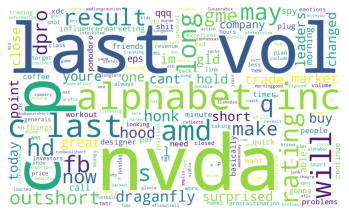

[0.5438560018379741,
 0.5416918817137915,
 0.5194117323860753,
 0.5471776591640604,
 0.5471776591640604,
 0.4560424558888775,
 0.7547519315160822,
 0.5598091979735752,
 0.06319256118121747,
 0.16665595507680764,
 0.6505937055470324,
 0.06470776321798505,
 0.19237947122917784,
 0.44636149195433206,
 0.610139378596798,
 1.0011377100145398,
 0.6666666666666666,
 0.3333333333333333]

In [145]:
def get_today_info(company):
    today = "2022-05-25"
    y, m, d = int(today.split('-')[0]), int(today.split('-')[1]), int(today.split('-')[2])

    words, pos, neg = date_prediction(company, y, m, d)

    nextday = getNextDay(y, m, d)
    
    data = pd.read_csv("data/stock/{}_Today.csv".format(company))
    data['Date'] = data.index

    last_idx = data.shape[0] - 1

    stock = data
    ema = TA.EMA(stock, 50).round(decimals=8)
    adx = TA.ADX(stock).round(decimals=8)
    macd = TA.MACD(stock).round(decimals=8)
    rsi = TA.RSI(stock).round(decimals=8)
    sar = TA.SAR(stock).round(decimals=8)
    cci = TA.CCI(stock).round(decimals=8)
    stoch = TA.STOCH(stock).round(decimals=8)
    bop = TA.BOP(stock).round(decimals=8)
    do = TA.DO(stock).round(decimals=8)
    vwap = TA.VWAP(stock).round(decimals=8)

    hist_data = []
    for i in range(20, last_idx):
        hist_data.append([data['Open'][i], data['High'][i], data['Low'][i], data['Close'][i], data['Adj Close'][i],
                          data['Volume'][i]])
    indicators = []
    for i in range(20, last_idx + 1):
        ind = [ema[i], adx[i], macd['MACD'][i], rsi[i], sar[i], cci[i], stoch[i], bop[i], do['MIDDLE'][i], vwap[i]]
        indicators.append(ind)

    stock_data = np.concatenate((hist_data, indicators[:-1]), 1)
    today_data = [data['Open'][last_idx], data['High'][last_idx], data['Low'][last_idx], data['Close'][last_idx],
                  data['Adj Close'][last_idx], data['Volume'][last_idx]] + indicators[-1]

    scaler = MinMaxScaler()
    scaler.fit(stock_data)

    stock_data = scaler.transform(stock_data)
    today_data = scaler.transform([today_data])[0]

    today_data = list(today_data) + [pos, neg]

    company_list = ["GOOG", "AMZN", "MSFT", "AAPL"]
    # generate wordcloud
    keywords = company_list + ['tsla', 'stock', 'tickers']
    for c in keywords:
        words = words.replace(c.lower(), "")

        # make wordcloud
    if len(words) != 0:
        wc = WordCloud(
            max_words=200,
            background_color='white',
            width=2000,
            height=1200
        )

        word_cloud = wc.generate(words)
        word_cloud.background_color = 'white'
        plt.imshow(word_cloud)
        plt.axis("off")
        plt.show()

    return today_data
get_today_info("GOOG")

Num of class=0:  496
Num of class=1:  577
[[0.09531495 0.08313142 0.09322168 ... 0.1084312  0.66666667 0.33333333]
 [0.09145719 0.08362197 0.09242763 ... 0.11354981 0.61290323 0.38709677]
 [0.07177577 0.05863742 0.06764907 ... 0.10785376 0.62068966 0.37931034]
 ...
 [0.63208736 0.6589533  0.6400939  ... 0.99748465 0.5        0.5       ]
 [0.65979444 0.67818843 0.67192895 ... 0.99842911 0.80952381 0.19047619]
 [0.6717991  0.71589331 0.6631651  ... 1.         0.64705882 0.35294118]]


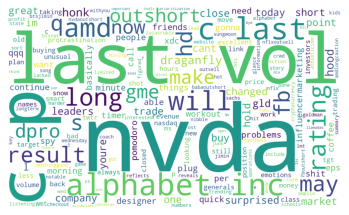

1/1 [==============================] - 0s 21ms/step


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


x.shape= (None, 30)
model.x = (None, 18, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 25ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.823256               Down
1                 LSTM  0.813953               Down
2        Random Forest  0.832558               Down
3  Logistic Regression  0.832558               Down
4                  SVM  0.823256                 Up
5          Naive Bayes  0.804651               Down
6                  KNN  0.781395               Down


In [149]:
def risk_prediction_all(company, start_time, end_time):
    stock_data, label = gather_data(company, start_time, end_time)
    today = get_today_info(company)
    today = np.array(today)
    X_train, X_test, y_train, y_test = train_test_split(
        stock_data, label, test_size=0.2, random_state=42)

    acc_list, pred_list = risk_prediction_ml(X_train, X_test, y_train, y_test, today)
    acc_list['lstm'], pred_list['lstm'] = risk_prediction_lstm(X_train, X_test, y_train, y_test, today)
    acc_list['tcn'], pred_list['tcn'] = risk_prediction_tcn(X_train, X_test, y_train, y_test, today)

    model = ['TCN', 'LSTM', 'Random Forest', 'Logistic Regression', 'SVM', 'Naive Bayes', 'KNN']
    acc = [acc_list['tcn'], acc_list['lstm'], acc_list['dt'], acc_list['lr'], acc_list['svm'], acc_list['nb'],
           acc_list['knn']]
    pred = [updown(pred_list['tcn']), updown(pred_list['lstm']), updown(pred_list['dt']), updown(pred_list['lr']),
            updown(pred_list['svm']), updown(pred_list['nb']), updown(pred_list['knn'])]
    df = pd.DataFrame(data={'Model': model, 'Accuracy': acc, 'Up/Down prediction': pred})
    print(df)

    #df.to_csv('data/updown-prediction-{}.csv'.format(company), index=False)
risk_prediction_all("GOOG","2018-01-01","2022-05-07")

Num of class=0:  475
Num of class=1:  598
[[0.03902547 0.03876869 0.04264727 ... 0.03519801 0.61764706 0.38235294]
 [0.03953695 0.03907582 0.04309984 ... 0.03290123 0.79069767 0.20930233]
 [0.0375422  0.03597025 0.03150677 ... 0.02605499 0.57575758 0.42424242]
 ...
 [0.82323458 0.83134253 0.8200112  ... 0.99733477 0.57692308 0.42307692]
 [0.8330548  0.84826978 0.84124782 ... 0.99849443 0.62068966 0.37931034]
 [0.8434207  0.88765268 0.86171842 ... 1.         0.69230769 0.30769231]]


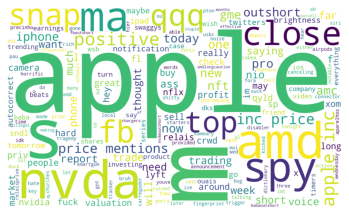

1/1 [==============================] - 0s 21ms/step


x.shape= (None, 30)
model.x = (None, 18, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 21ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.781395               Down
1                 LSTM  0.772093               Down
2        Random Forest  0.786047               Down
3  Logistic Regression  0.800000               Down
4                  SVM  0.809302               Down
5          Naive Bayes  0.702326               Down
6                  KNN  0.748837               Down


In [152]:
risk_prediction_all("AAPL","2018-01-01","2022-05-07")

Num of class=0:  508
Num of class=1:  565
[[0.04391159 0.03727847 0.07573862 ... 0.         0.61764706 0.38235294]
 [0.04128438 0.03196377 0.04904029 ... 0.00772997 0.82857143 0.17142857]
 [0.05479146 0.04791636 0.06091257 ... 0.0189411  0.625      0.375     ]
 ...
 [0.45955797 0.46445814 0.45316063 ... 0.99968131 0.68       0.32      ]
 [0.47334026 0.47745204 0.48977317 ... 0.99982129 0.90322581 0.09677419]
 [0.46955795 0.47560655 0.45980848 ... 1.         0.80645161 0.19354839]]


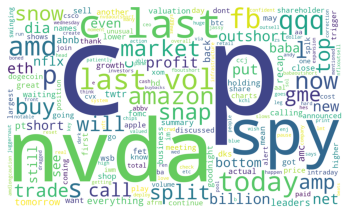

1/1 [==============================] - 0s 21ms/step


x.shape= (None, 30)
model.x = (None, 18, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 21ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.809302                 Up
1                 LSTM  0.846512                 Up
2        Random Forest  0.837209                 Up
3  Logistic Regression  0.827907                 Up
4                  SVM  0.818605               Down
5          Naive Bayes  0.790698               Down
6                  KNN  0.795349               Down


In [153]:
risk_prediction_all("AMZN","2018-01-01","2022-05-07")

Num of class=0:  496
Num of class=1:  577
[[0.02884019 0.024814   0.03746565 ... 0.00396737 0.70967742 0.29032258]
 [0.03286621 0.0273836  0.03773658 ... 0.00735913 0.66666667 0.33333333]
 [0.02841436 0.0193296  0.0296861  ... 0.00859931 0.75675676 0.24324324]
 ...
 [0.74098016 0.751745   0.74462976 ... 0.99804823 0.79310345 0.20689655]
 [0.76517495 0.74863847 0.75984048 ... 0.99888193 0.82142857 0.17857143]
 [0.75987147 0.77452633 0.74660371 ... 1.         0.92307692 0.07692308]]


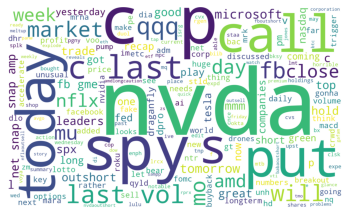

1/1 [==============================] - 0s 21ms/step


x.shape= (None, 30)
model.x = (None, 18, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 21ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.809302                 Up
1                 LSTM  0.823256                 Up
2        Random Forest  0.832558                 Up
3  Logistic Regression  0.823256                 Up
4                  SVM  0.813953                 Up
5          Naive Bayes  0.776744               Down
6                  KNN  0.767442                 Up


In [155]:
risk_prediction_all("MSFT","2018-01-01","2022-05-07")

In [ ]:
##################################################################################


In [225]:
def just_sentiment_data(company, start_time, end_time):

    # the time of tweets collected, change it when collecting more tweets to train the model
    start_time = "2018-01-01"
    end_time = "2022-05-07"

    sentiment = sentiment_analysis(company)
    
    data = sentiment
    data.drop(data[(data.pos == 0) & (data.neg == 0)].index, inplace=True)
    data = data.reset_index(drop=True)
    
    # data = stock

    stockforlabeling = pd.read_csv("data/stock/{}.csv".format(company))
    last_idx = stockforlabeling.shape[0] - 1

    # add label
    label = []
    for i in range(20, last_idx):
        if stockforlabeling['Open'][i + 1] >= stockforlabeling['Open'][i]:
            label.append(1)
        else:
            label.append(0)
    label = np.array(label)

    print("Num of class=0: ", sum(i == 0 for i in label))
    print("Num of class=1: ", sum(i == 1 for i in label))

    d=data.head(1075)
    d1=d.drop(['date'],axis=1)
    return d1,label   

just_sentiment_data("GOOG","2018-01-01","2022-05-07")  

Num of class=0:  498
Num of class=1:  577


(           pos       neg
 0     0.857143  0.142857
 1     0.666667  0.333333
 2     0.833333  0.166667
 3     0.500000  0.500000
 4     0.583333  0.416667
 ...        ...       ...
 1070  0.833333  0.166667
 1071  0.857143  0.142857
 1072  0.681818  0.318182
 1073  0.590909  0.409091
 1074  0.642857  0.357143
 
 [1075 rows x 2 columns],
 array([0, 0, 0, ..., 1, 0, 0]))

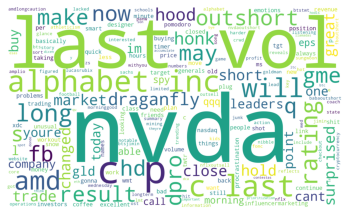

[0.6666666666666666, 0.3333333333333333]

In [226]:
def get_today_info_just_sentiment(company):
    today = "2022-05-25"
    y, m, d = int(today.split('-')[0]), int(today.split('-')[1]), int(today.split('-')[2])

    words, pos, neg = date_prediction(company, y, m, d)

    nextday = getNextDay(y, m, d)
    

    company_list = ["GOOG", "AMZN", "MSFT", "AAPL"]
    # generate wordcloud
    keywords = company_list + ['tsla', 'stock', 'tickers']
    for c in keywords:
        words = words.replace(c.lower(), "")

        # make wordcloud
    if len(words) != 0:
        wc = WordCloud(
            max_words=200,
            background_color='white',
            width=2000,
            height=1200
        )

        word_cloud = wc.generate(words)
        word_cloud.background_color = 'white'
        plt.imshow(word_cloud)
        plt.axis("off")
        plt.show()

        return([pos,neg])
    
get_today_info_just_sentiment("GOOG")

Num of class=0:  498
Num of class=1:  577


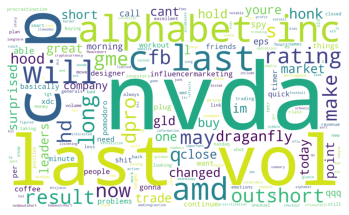

(2,)
1/1 [==============================] - 0s 29ms/step


x.shape= (None, 30)
model.x = (None, 2, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 21ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.502326                 Up
1                 LSTM  0.516279                 Up
2        Random Forest  0.553488                 Up
3  Logistic Regression  0.516279                 Up
4                  SVM  0.516279                 Up
5          Naive Bayes  0.516279                 Up
6                  KNN  0.544186               Down


In [230]:
def risk_prediction_just_sentiment(company, start_time, end_time):
    
    stock_data, label = just_sentiment_data(company, start_time, end_time)
    today = get_today_info_just_sentiment(company)
    stock_data=stock_data.to_numpy()
    today = np.array(today)
    X_train, X_test, y_train, y_test = train_test_split(
        stock_data, label, test_size=0.2, random_state=42)

    acc_list, pred_list = risk_prediction_ml(X_train, X_test, y_train, y_test, today)
    acc_list['lstm'], pred_list['lstm'] = risk_prediction_lstm(X_train, X_test, y_train, y_test, today)
    acc_list['tcn'], pred_list['tcn'] = risk_prediction_tcn(X_train, X_test, y_train, y_test, today)

    model = ['TCN', 'LSTM', 'Random Forest', 'Logistic Regression', 'SVM', 'Naive Bayes', 'KNN']
    acc = [acc_list['tcn'], acc_list['lstm'], acc_list['dt'], acc_list['lr'], acc_list['svm'], acc_list['nb'],
           acc_list['knn']]
    pred = [updown(pred_list['tcn']), updown(pred_list['lstm']), updown(pred_list['dt']), updown(pred_list['lr']),
            updown(pred_list['svm']), updown(pred_list['nb']), updown(pred_list['knn'])]
    df = pd.DataFrame(data={'Model': model, 'Accuracy': acc, 'Up/Down prediction': pred})
    print(df)

risk_prediction_just_sentiment("GOOG","2018-01-01","2022-05-07")

Num of class=0:  477
Num of class=1:  598


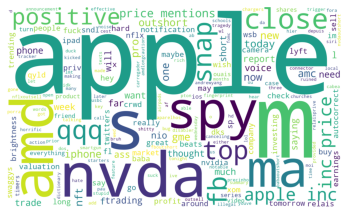

(2,)
1/1 [==============================] - 0s 22ms/step


x.shape= (None, 30)
model.x = (None, 2, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 23ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.479070                 Up
1                 LSTM  0.553488                 Up
2        Random Forest  0.534884                 Up
3  Logistic Regression  0.553488                 Up
4                  SVM  0.553488                 Up
5          Naive Bayes  0.562791                 Up
6                  KNN  0.506977                 Up


In [231]:
risk_prediction_just_sentiment("AAPL","2018-01-01","2022-05-07")

Num of class=0:  510
Num of class=1:  565


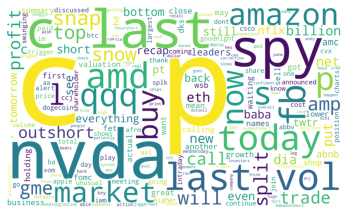

(2,)
1/1 [==============================] - 0s 53ms/step


x.shape= (None, 30)
model.x = (None, 2, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 21ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.525581               Down
1                 LSTM  0.530233                 Up
2        Random Forest  0.520930               Down
3  Logistic Regression  0.544186                 Up
4                  SVM  0.530233                 Up
5          Naive Bayes  0.548837               Down
6                  KNN  0.534884               Down


In [232]:
risk_prediction_just_sentiment("AMZN","2018-01-01","2022-05-07")

Num of class=0:  498
Num of class=1:  577


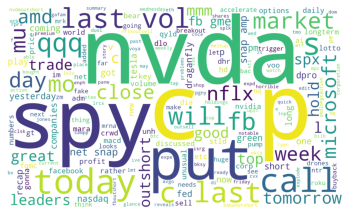

(2,)
1/1 [==============================] - 0s 24ms/step


x.shape= (None, 30)
model.x = (None, 2, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 21ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.534884                 Up
1                 LSTM  0.544186                 Up
2        Random Forest  0.539535                 Up
3  Logistic Regression  0.544186                 Up
4                  SVM  0.544186                 Up
5          Naive Bayes  0.544186                 Up
6                  KNN  0.502326                 Up


In [233]:
risk_prediction_just_sentiment("MSFT","2018-01-01","2022-05-07")

In [ ]:
##################################################################################


In [170]:
def get_today_info_just_stock(company):
    today = "2022-05-25"
    y, m, d = int(today.split('-')[0]), int(today.split('-')[1]), int(today.split('-')[2])


    nextday = getNextDay(y, m, d)
    
    data = pd.read_csv("data/stock/{}_Today.csv".format(company))
    data['Date'] = data.index

    last_idx = data.shape[0] - 1

    stock = data
    ema = TA.EMA(stock, 50).round(decimals=8)
    adx = TA.ADX(stock).round(decimals=8)
    macd = TA.MACD(stock).round(decimals=8)
    rsi = TA.RSI(stock).round(decimals=8)
    sar = TA.SAR(stock).round(decimals=8)
    cci = TA.CCI(stock).round(decimals=8)
    stoch = TA.STOCH(stock).round(decimals=8)
    bop = TA.BOP(stock).round(decimals=8)
    do = TA.DO(stock).round(decimals=8)
    vwap = TA.VWAP(stock).round(decimals=8)

    hist_data = []
    for i in range(20, last_idx):
        hist_data.append([data['Open'][i], data['High'][i], data['Low'][i], data['Close'][i], data['Adj Close'][i],
                          data['Volume'][i]])
    indicators = []
    for i in range(20, last_idx + 1):
        ind = [ema[i], adx[i], macd['MACD'][i], rsi[i], sar[i], cci[i], stoch[i], bop[i], do['MIDDLE'][i], vwap[i]]
        indicators.append(ind)

    stock_data = np.concatenate((hist_data, indicators[:-1]), 1)
    today_data = [data['Open'][last_idx], data['High'][last_idx], data['Low'][last_idx], data['Close'][last_idx],
                  data['Adj Close'][last_idx], data['Volume'][last_idx]] + indicators[-1]

    scaler = MinMaxScaler()
    scaler.fit(stock_data)

    stock_data = scaler.transform(stock_data)
    today_data = scaler.transform([today_data])[0]

    print(today_data.shape)
    return today_data
get_today_info_just_stock("GOOG")

(16,)


array([0.543856  , 0.54169188, 0.51941173, 0.54717766, 0.54717766,
       0.45604246, 0.75475193, 0.5598092 , 0.06319256, 0.16665596,
       0.65059371, 0.06470776, 0.19237947, 0.44636149, 0.61013938,
       1.00113771])

In [162]:
def just_stock_data(company, start_time, end_time):

    
    data = pd.read_csv("data/stock/{}.csv".format(company))
    

    

    last_idx = data.shape[0] - 1

    hist_data = []
    for i in range(20, last_idx):
        hist_data.append([data['Open'][i], data['High'][i], data['Low'][i], data['Close'][i], data['Adj Close'][i],
                          data['Volume'][i]])

    # Technical Indicators
    stock = data
    ema = TA.EMA(stock, 50).round(decimals=8)
    adx = TA.ADX(stock).round(decimals=8)
    macd = TA.MACD(stock).round(decimals=8)
    rsi = TA.RSI(stock).round(decimals=8)
    sar = TA.SAR(stock).round(decimals=8)
    cci = TA.CCI(stock).round(decimals=8)
    stoch = TA.STOCH(stock).round(decimals=8)
    bop = TA.BOP(stock).round(decimals=8)
    do = TA.DO(stock).round(decimals=8)
    vwap = TA.VWAP(stock).round(decimals=8)

    indicators = []
    for i in range(20, last_idx):
        ind = [ema[i], adx[i], macd['MACD'][i], rsi[i], sar[i], cci[i], stoch[i], bop[i], do['MIDDLE'][i], vwap[i]]
        indicators.append(ind)

    stock_data = np.concatenate((hist_data, indicators), 1)

    # add label
    label = []
    for i in range(20, last_idx):
        if data['Open'][i + 1] >= data['Open'][i]:
            label.append(1)
        else:
            label.append(0)
    label = np.array(label)

    print("Num of class=0: ", sum(i == 0 for i in label))
    print("Num of class=1: ", sum(i == 1 for i in label))

    # Min-Max normalization
    scaler = MinMaxScaler()
    scaler.fit(stock_data)

    stock_data = scaler.transform(stock_data)
    print(stock_data.shape)
    return stock_data, label    

just_stock_data("GOOG","2018-01-01","2022-05-07")  

Num of class=0:  498
Num of class=1:  577
(1075, 16)


(array([[0.09531495, 0.08313142, 0.09322168, ..., 0.47695971, 0.06479712,
         0.10806728],
        [0.09145719, 0.08362197, 0.09242763, ..., 0.65583243, 0.06464632,
         0.11316871],
        [0.07177577, 0.05863742, 0.06764907, ..., 0.17697805, 0.05180498,
         0.10749177],
        ...,
        [0.6717991 , 0.71589331, 0.6631651 , ..., 0.8116141 , 0.75999092,
         0.99664374],
        [0.69328817, 0.69715618, 0.6576809 , ..., 0.21000667, 0.74901597,
         0.9985335 ],
        [0.64771709, 0.66051327, 0.64742755, ..., 0.5211089 , 0.74159616,
         1.        ]]),
 array([0, 0, 0, ..., 1, 0, 0]))

In [172]:
def risk_prediction_just_stock(company, start_time, end_time):
        
    stock = pd.read_csv("data/stock/{}.csv".format(company))
    stock_data, label = just_stock_data(company, start_time, end_time)
    today = get_today_info_just_stock(company)
    today = np.array(today)
    X_train, X_test, y_train, y_test = train_test_split(
        stock_data, label, test_size=0.2, random_state=42)

    acc_list, pred_list = risk_prediction_ml(X_train, X_test, y_train, y_test, today)
    acc_list['lstm'], pred_list['lstm'] = risk_prediction_lstm(X_train, X_test, y_train, y_test, today)
    acc_list['tcn'], pred_list['tcn'] = risk_prediction_tcn(X_train, X_test, y_train, y_test, today)

    model = ['TCN', 'LSTM', 'Random Forest', 'Logistic Regression', 'SVM', 'Naive Bayes', 'KNN']
    acc = [acc_list['tcn'], acc_list['lstm'], acc_list['dt'], acc_list['lr'], acc_list['svm'], acc_list['nb'],
           acc_list['knn']]
    pred = [updown(pred_list['tcn']), updown(pred_list['lstm']), updown(pred_list['dt']), updown(pred_list['lr']),
            updown(pred_list['svm']), updown(pred_list['nb']), updown(pred_list['knn'])]
    df = pd.DataFrame(data={'Model': model, 'Accuracy': acc, 'Up/Down prediction': pred})
    print(df)

    #df.to_csv('data/updown-prediction-{}.csv'.format(company), index=False)
risk_prediction_just_stock("GOOG","2018-01-01","2022-05-07")

Num of class=0:  498
Num of class=1:  577
(1075, 16)
(16,)
1/1 [==============================] - 0s 20ms/step


x.shape= (None, 30)
model.x = (None, 16, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 23ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.841860               Down
1                 LSTM  0.837209                 Up
2        Random Forest  0.846512               Down
3  Logistic Regression  0.837209               Down
4                  SVM  0.846512                 Up
5          Naive Bayes  0.837209               Down
6                  KNN  0.813953                 Up


In [174]:
risk_prediction_just_stock("AAPL","2018-01-01","2022-05-07")

Num of class=0:  477
Num of class=1:  598
(1075, 16)
(16,)
1/1 [==============================] - 0s 24ms/step


x.shape= (None, 30)
model.x = (None, 16, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 23ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.846512               Down
1                 LSTM  0.818605               Down
2        Random Forest  0.813953               Down
3  Logistic Regression  0.827907               Down
4                  SVM  0.832558               Down
5          Naive Bayes  0.804651               Down
6                  KNN  0.800000               Down


In [176]:
risk_prediction_just_stock("AMZN","2018-01-01","2022-05-07")

Num of class=0:  510
Num of class=1:  565
(1075, 16)
(16,)
1/1 [==============================] - 0s 21ms/step


x.shape= (None, 30)
model.x = (None, 16, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 23ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.841860                 Up
1                 LSTM  0.823256                 Up
2        Random Forest  0.827907               Down
3  Logistic Regression  0.823256                 Up
4                  SVM  0.832558               Down
5          Naive Bayes  0.851163               Down
6                  KNN  0.776744               Down


In [175]:
risk_prediction_just_stock("MSFT","2018-01-01","2022-05-07")

Num of class=0:  498
Num of class=1:  577
(1075, 16)
(16,)
1/1 [==============================] - 0s 20ms/step


x.shape= (None, 30)
model.x = (None, 16, 1)
model.y = (None, 2)
1/1 [==============================] - 0s 30ms/step
                 Model  Accuracy Up/Down prediction
0                  TCN  0.841860                 Up
1                 LSTM  0.837209                 Up
2        Random Forest  0.832558                 Up
3  Logistic Regression  0.823256                 Up
4                  SVM  0.841860                 Up
5          Naive Bayes  0.851163               Down
6                  KNN  0.800000                 Up


In [248]:
import streamlit as st

ImportError: cannot import name 'TypeGuard' from 'typing_extensions' (C:\ProgramData\Anaconda3\lib\site-packages\typing_extensions.py)